In [18]:
# %%writefile utils.py

import numpy as np
import json

def softmax(logits: np.ndarray):
    exp_logits = np.exp(logits - logits.max())
    return exp_logits/np.sum(exp_logits)

def return_probabilities(state, qvalue_state, kind):
    index_state = np.array(list(map(int, list(state))))
    probs = np.zeros_like(qvalue_state, dtype=np.float)
    logits = qvalue_state[index_state == 0]
    if kind == "greedy":
        p = np.zeros_like(logits)
        p[np.where(logits - logits.max() == 0)] = 1 # Give the same probability when there are more than one maximum
        p = p.mean()
    elif kind == "softmax":
        p = softmax(logits)
    elif kind == "random":
        p = 1/len(logits)
    else:
        raise NotImplementedError
    probs[index_state == 0] = p
    return list(probs)

def generate_json_policy(policy, json_policy_path):
    with open(json_policy_path, 'w') as json_file:
        json.dump(policy, json_file, indent=2)

def read_json_policy(json_policy_path):
    with open(json_policy_path, 'r') as json_file:
        policy = json.load(json_file)
    return policy

Overwriting utils.py


In [19]:
# %%writefile q_agent_model.py 

import numpy as np
from utils import return_probabilities, generate_json_policy

class Player:
    def __init__(self, num_actions, gamma, learning_rate, epsilon) -> None:
        self.qfunction = {}
        self._gamma = gamma
        self._alpha = learning_rate
        self._epsilon =  epsilon
        self._num_actions = num_actions
    
    def act(self, state, eval = False):
        if state not in self.qfunction:
            self.qfunction[state] = np.zeros(self._num_actions)
        Q_s = self.qfunction[state]
        if (eval or np.random.uniform() > self._epsilon) and np.any(Q_s - Q_s[0]):
            action = np.argmax(self.qfunction[state])
        else :
            action = np.random.randint(self._num_actions)
        return action
    

    def update(self, state, action, next_state, reward, done) -> None:
        if state not in self.qfunction:
            self.qfunction[state] = np.zeros(self._num_actions)
        
        if done:
            self.qfunction[state][action] = (1-self._alpha) * self.qfunction[state][action] + self._alpha * reward
        else:
            if next_state not in self.qfunction:
                self.qfunction[next_state] = np.zeros(self._num_actions)
            self.qfunction[state][action] = (1-self._alpha) * self.qfunction[state][action] + self._alpha * (reward + self._gamma * self.qfunction[next_state].max()) 
    
    def generate_policy(self, kind, json_policy_path = None):
        policy = {}
        for state, qvalue in self.qfunction.items():
            if '0' in state: # only consider the case that there is an empty slot
                policy[state] = return_probabilities(state=state, qvalue_state=qvalue, kind = kind)
        if json_policy_path is not None:    
            generate_json_policy(policy, json_policy_path)
        return policy


def run_episode(player1, player2, environment, eval, max_step = 100):
    state = environment.reset()
    n_steps = 0
    player = [player1, player2]
    rewards = [0,0]
    dones = [False, False]
    p = 0
    winners = []
    while True:
        action = player[p].act(state, eval=eval)
        next_state, reward, done, switch = environment.step(action)
        
        if not eval:
            player[p].update(state, action, next_state, reward, done)
        rewards[p] += reward
        dones[p] = done
        if done:
            winners.append(p+1)
        n_steps += 1
        state = next_state
        if all(dones) or n_steps > max_step:
            break
        if switch: # do not pass the hand until player put in an empty place
            p = int(not p) 
    winner = winners[0] if winners else 0
    return rewards, winner

Overwriting q_agent_model.py


In [1]:
from tictactoe import TicTacToe
from q_agent_model import Player, run_episode
from utils import generate_json_policy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
environment = TicTacToe()
player1 = Player(environment.num_actions, gamma=1, learning_rate=0.0001, epsilon= .9)
player2 = Player(environment.num_actions, gamma=1, learning_rate=0.0001, epsilon= .9)

num_episodes = 100000
eval_every_N = 10 
num_eval_episodes = 3

max_step = 100

all_rewards = []
episodes = []
winners = []
# print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
# print("------------------------------------------------------")
try:
    for episode in tqdm(range(num_episodes)):
        run_episode(player1, player2, environment, eval=False, max_step = max_step)

        if episode % eval_every_N == 0:
            rewards_list = []
            winners_list = [0,0,0]
            for _ in range(num_eval_episodes):
                rewards, winner =run_episode(player1, player2, environment, eval=True, max_step = max_step)
                rewards_list.append(rewards)
                winners_list[winner] += 1
            rewards = np.mean(rewards_list, axis=-1)
            winners.append(winners_list.copy())
            # print(f"\t{episode}\t|\t{rewards[0]:.2f} vs {rewards[1]:.2f}")
            all_rewards.append(rewards)
            episodes.append(episode)
except KeyboardInterrupt:
    pass

all_rewards = np.array(all_rewards).T
winners = np.array(winners).T

print("The highest index is ", len(episodes)-1)

100%|██████████| 100000/100000 [00:13<00:00, 7366.58it/s]


The highest index is  9999


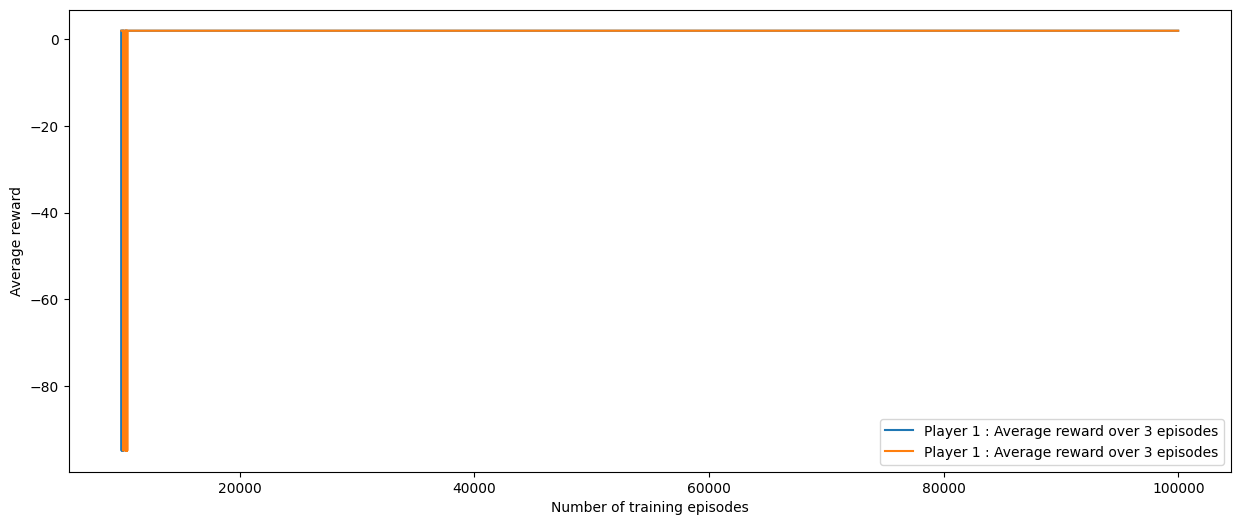

In [3]:
from_index = 990
plt.figure(figsize=(15, 6))
plt.xlabel('Number of training episodes')
plt.ylabel('Average reward')
plt.plot(episodes[from_index:], all_rewards[0][from_index:], label=f"Player 1 : Average reward over {num_eval_episodes} episodes")
plt.plot(episodes[from_index:], all_rewards[1][from_index:], label=f"Player 1 : Average reward over {num_eval_episodes} episodes")
plt.legend()

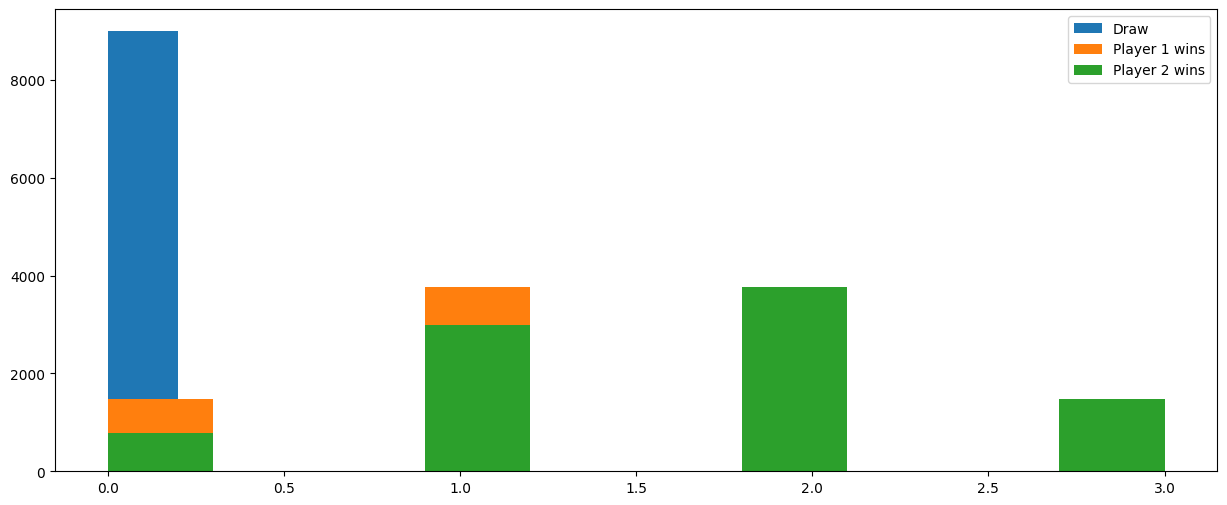

In [4]:
end_index = -1 
plt.figure(figsize=(15, 6))
plt.hist(winners[0][from_index:end_index], label=f"Draw")
plt.hist(winners[1][from_index:end_index], label=f"Player 1 wins")
plt.hist(winners[2][from_index:end_index], label=f"Player 2 wins")
plt.legend()

In [5]:
draw, p1, p2 = np.ceil(np.mean(winners[:,from_index:end_index],axis=-1)*100/num_eval_episodes)
print(f"{draw}% is Draw\n{p1}% Player 1 wins\n{100-draw-p1}% Player 2 wins")

1.0% is Draw
45.0% Player 1 wins
54.0% Player 2 wins


In [6]:
easy = player1.generate_policy(kind = "random",json_policy_path="json_agents/easy.json")

print("Random policy generated successfully")

Random policy generated successfully


In [7]:
player1.generate_policy(kind = "softmax", json_policy_path = f"json_agents/medium_player1.json")
player2.generate_policy(kind = "softmax", json_policy_path = f"json_agents/medium_player2.json")
print("Medium policy generated successfully")

Medium policy generated successfully


In [8]:
p1h = player1.generate_policy(kind = "greedy")
p1h["000000000"] = easy["000000000"] # start at a random place

generate_json_policy(p1h, json_policy_path = f"json_agents/hard_player1.json")
player2.generate_policy(kind = "greedy", json_policy_path = f"json_agents/hard_player2.json")
print("Hard policy generated successfully")

Hard policy generated successfully


In [16]:
def sym(hash):
    hash = hash.replace("1","a")
    hash = hash.replace("2", "b")
    hash = hash.replace("b", "1")
    hash = hash.replace("a", "2")
    return hash

In [17]:
# p2h = {sym(hash): prob for hash, prob in p1h.items()}
# generate_json_policy(p2h, json_policy_path = f"json_agents/hard_player2.json")
print("Hard policy generated successfully")

Hard policy generated successfully
